# MIE451/1513 Decision Support System -- Data Science Solution

## Be sure to let us know:
i. what location you chose (and remember to sign up on Piazza so there are no duplicates),

ii. what preprocessing steps you implemented


# Q1

choose 154980 Barrie, ON as the target location. Import libraries and read data.

In [228]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [229]:
# read data
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv('review.csv',
                          header=None,
                          names=columnNames)
hotelDf.head()  # 1924 rows × 10 columns 

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode
0,data/ca/154980/182801/461467948.html,Comfort Inn &amp; Suites,"""Snow falling all night, so we stayed here. We...",4,positive,"February 20, 2017",210 Essa Rd,"('Barrie',)",Ontario,L4N 3L1
1,data/ca/154980/182801/857658580.html,Comfort Inn &amp; Suites,"""During check In reception clerk asked us to d...",1,negative,"August 31, 2022",210 Essa Rd,"('Barrie',)",Ontario,L4N 3L1
2,data/ca/154980/182801/828573069.html,Comfort Inn &amp; Suites,"""The hotel was large and not as modern as othe...",4,positive,"February 19, 2022",210 Essa Rd,"('Barrie',)",Ontario,L4N 3L1
3,data/ca/154980/182801/656041688.html,Comfort Inn &amp; Suites,"""excellent place to stay, the staff go above a...",5,positive,"March 3, 2019",210 Essa Rd,"('Barrie',)",Ontario,L4N 3L1
4,data/ca/154980/182801/619945064.html,Comfort Inn &amp; Suites,"""Overall this hotel offers great value and is ...",4,positive,"September 27, 2018",210 Essa Rd,"('Barrie',)",Ontario,L4N 3L1


In [230]:
# select hotels only appears in Barrie
hotelDf = hotelDf[hotelDf["City"] == "('Barrie',)"]


In [231]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [232]:
reviews = hotelDf['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
reviewDF.head()

100%|██████████| 1484/1484 [00:01<00:00, 807.60it/s]


,reviewCol,vader
0,"""Snow falling all night, so we stayed here. We...",0.9265
1,"""During check In reception clerk asked us to d...",-0.9832
2,"""The hotel was large and not as modern as othe...",0.7684
3,"""excellent place to stay, the staff go above a...",0.9744
4,"""Overall this hotel offers great value and is ...",0.9633


## data preprocessing

In [233]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf


In [234]:
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(hotelDf, reviewDF, topk)

In [235]:
finaldf.head() #1924 x 505

,hotelName,ratingScore,groundTruth,reviewCol,vader,breakfast,clean,would,great,good,...,none,fast,whole,owner,along,review,others,expensive,must,toronto
0,Comfort Inn &amp; Suites,4,positive,"""Snow falling all night, so we stayed here. We...",0.9265,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Comfort Inn &amp; Suites,1,negative,"""During check In reception clerk asked us to d...",-0.9832,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Comfort Inn &amp; Suites,4,positive,"""The hotel was large and not as modern as othe...",0.7684,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Comfort Inn &amp; Suites,5,positive,"""excellent place to stay, the staff go above a...",0.9744,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Comfort Inn &amp; Suites,4,positive,"""Overall this hotel offers great value and is ...",0.9633,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## Average Vader Sentiment and average ground truth rating per hotel

In [236]:
averagedf = pd.DataFrame(columns = ["Average Vader Sentiment", "Average ground truth rating","number of ratings"])

for i in finaldf.hotelName.unique().tolist():
  single_hotel = finaldf.groupby("hotelName").get_group(i)
  single_rs= single_hotel["ratingScore"].mean()
  single_vadar = single_hotel["vader"].mean()
  single_rn = single_hotel.shape[0]
  averagedf.loc[i, "Average Vader Sentiment"] = single_vadar
  averagedf.loc[i, "Average ground truth rating"] = single_rs
  averagedf.loc[i, "number of ratings"] = single_rn

In [237]:
averagedf

,Average Vader Sentiment,Average ground truth rating,number of ratings
Comfort Inn &amp; Suites,0.434899,3.18,100
"Holiday Inn Express &amp; Suites Barrie, an IHG Hotel",0.732237,4.0,100
Comfort Inn - Barrie / Hart Dr.,0.663972,3.42,100
Travelodge by Wyndham Downtown Barrie,0.18806,2.44,100
Three Wishes B&amp;B,0.95949,4.823529,68
Horseshoe Resort,0.42365,3.42,100
Monte Carlo Inn Barrie Suites,0.424428,3.34,100
Richmond Manor Bed &amp; Breakfast,0.952257,4.714286,14
Quality Inn,0.385173,2.73,100
Clydesdale House,0.959966,4.965517,29


## rank hotels

In [238]:
# sorting
sort_rating = averagedf.sort_values(by='Average ground truth rating', ascending=False)
sort_vadar = averagedf.sort_values(by='Average Vader Sentiment', ascending=False)

In [239]:
# show top5 and bottom5 rankings
rankdf = pd.DataFrame(columns = ["Top5 Hotels (Ground truth rating)", "Top5 Hotels (Vader Score)", "Bottom5 Hotels (Ground truth rating)", "Bottom5 Hotels (Vader Score)"])

rankdf['Top5 Hotels (Ground truth rating)'] = sort_rating.iloc[:5,:].index.tolist()
rankdf['Top5 Hotels (Vader Score)'] = sort_vadar.iloc[:5,:].index.tolist()

rankdf['Bottom5 Hotels (Ground truth rating)'] = sort_rating.iloc[-5:,:].index.tolist()
rankdf['Bottom5 Hotels (Vader Score)'] = sort_vadar.iloc[-5:,:].index.tolist()


In [240]:
rankdf

,Top5 Hotels (Ground truth rating),Top5 Hotels (Vader Score),Bottom5 Hotels (Ground truth rating),Bottom5 Hotels (Vader Score)
0,Clydesdale House,Clydesdale House,Super 8 by Wyndham Barrie,Quality Inn
1,Parkside House,Three Wishes B&amp;B,Quality Inn,Super 8 by Wyndham Barrie
2,Three Wishes B&amp;B,Parkside House,"Allure Hotel &amp; Conference Centre, Ascend H...",Travelodge by Wyndham Downtown Barrie
3,Richmond Manor Bed &amp; Breakfast,Richmond Manor Bed &amp; Breakfast,Travelodge by Wyndham Downtown Barrie,"Allure Hotel &amp; Conference Centre, Ascend H..."
4,Water&#39;s Edge B &amp; B,Water&#39;s Edge B &amp; B,Barrie Motel,Barrie Motel


same set of Top 5 and Bottom 5 hotels to appear in both ranking lists but in a different order.

# Q2

## term frequency

In [241]:
def getTopKWords_gt(df, kwords, groundTruth):
    #groundTruth = "positive" or "negative"

    stop = get_stop_words()
    counter = Counter()

    gt_df = df[df["groundTruth"] == groundTruth]
    reviews = gt_df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [242]:
# positive reviews
getTopKWords_gt(finaldf, 50, "positive")

[('clean', 520),
 ('breakfast', 511),
 ('great', 443),
 ('good', 346),
 ('friendly', 283),
 ('nice', 280),
 ('barrie', 268),
 ('comfortable', 267),
 ('would', 261),
 ('stayed', 230),
 ('well', 201),
 ('night', 188),
 ('place', 188),
 ('area', 159),
 ('bed', 155),
 ('one', 152),
 ('pool', 150),
 ('helpful', 149),
 ('hot', 146),
 ('time', 144),
 ('desk', 143),
 ('location', 142),
 ('also', 133),
 ('front', 131),
 ('beds', 128),
 ('recommend', 127),
 ('close', 126),
 ('back', 126),
 ('quiet', 118),
 ('check', 117),
 ('nthe', 117),
 ('get', 115),
 ('everything', 114),
 ('inn', 110),
 ('definitely', 109),
 ('always', 107),
 ('like', 106),
 ('little', 103),
 ('coffee', 102),
 ('could', 101),
 ('family', 95),
 ('home', 95),
 ('really', 94),
 ('excellent', 92),
 ('service', 91),
 ('easy', 88),
 ('morning', 86),
 ('day', 86),
 ('small', 86),
 ('free', 85)]

In [243]:
# negative reviews
getTopKWords_gt(finaldf, 50, "negative")

[('would', 308),
 ('breakfast', 258),
 ('night', 258),
 ('one', 246),
 ('desk', 225),
 ('clean', 220),
 ('get', 216),
 ('front', 199),
 ('u2019t', 195),
 ('stayed', 181),
 ('like', 173),
 ('place', 170),
 ('could', 167),
 ('check', 164),
 ('good', 162),
 ('time', 149),
 ('bed', 148),
 ('nthe', 147),
 ('told', 145),
 ('back', 140),
 ('door', 139),
 ('even', 124),
 ('nice', 124),
 ('bathroom', 122),
 ('dirty', 121),
 ('booked', 120),
 ('pool', 118),
 ('said', 117),
 ('well', 112),
 ('day', 110),
 ('never', 107),
 ('friendly', 105),
 ('floor', 103),
 ('morning', 103),
 ('also', 101),
 ('work', 99),
 ('great', 99),
 ('people', 99),
 ('area', 97),
 ('shower', 95),
 ('service', 95),
 ('went', 93),
 ('barrie', 91),
 ('beds', 90),
 ('asked', 88),
 ('water', 87),
 ('around', 87),
 ('next', 87),
 ('manager', 85),
 ('location', 81)]

The location specific word "barrie" appears in both positive review list and negative review list. 

The words such as breakfast, friendly, great appeared in both lists. Some of them surprises me since there are some positive words also showed in negative reviews. 

## top50 noun-phrases

In [244]:
grammar = r"""
NBAR:
{<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
NP:
{<NBAR><IN><NBAR>}
{<NBAR>} # Above, connected with in/of/etc...
"""

In [245]:
tagger = PerceptronTagger()
pos_tag = tagger.tag

# Create phrase tree
chunker = nltk.RegexpParser(grammar)

# to make the results more useable, we clean up the tree results shown above. 
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
      
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [246]:
def getTopKNP(df, kNPs, groundTruth, chunker,pos_tag):

    counter = Counter()

    gt_df = df[df["groundTruth"] == groundTruth]
    reviews = gt_df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk


In [247]:
getTopKNP(finaldf, 50, "positive", chunker,pos_tag) 

[('front desk', 57),
 ('hot tub', 37),
 ('free breakfast', 21),
 ('comfort inn', 18),
 ('three wish', 18),
 ('great place', 15),
 ('next time', 15),
 ('comfort bed', 14),
 ('breakfast area', 13),
 ('complimentari breakfast', 12),
 ('good locat', 11),
 ('first time', 11),
 ('ground floor', 11),
 ('great experi', 11),
 ('great time', 10),
 ('queen bed', 10),
 ('great breakfast', 10),
 ('barri area', 10),
 ('good valu', 10),
 ('hot breakfast', 9),
 ('good size', 9),
 ('second floor', 9),
 ('continent breakfast', 9),
 ('great locat', 8),
 ('easi access', 8),
 ('mont carlo inn', 8),
 ('great valu', 7),
 ('park lot', 7),
 ('first floor', 7),
 ('great job', 7),
 ('qualiti inn', 7),
 ('main floor', 7),
 ('short walk', 7),
 ('clydesdal hous', 7),
 ('fairfield inn', 7),
 ('tim horton', 6),
 ('next morn', 6),
 ('next door', 6),
 ('good breakfast', 6),
 ('mini fridg', 6),
 ('minut drive', 6),
 ('gener manag', 6),
 ('clean breakfast', 5),
 ('wasaga beach', 5),
 ('reason price', 5),
 ('next day', 5)

In [248]:
getTopKNP(finaldf, 50, "negative", chunker,pos_tag) 

[('front desk', 108),
 ('hot tub', 23),
 ('credit card', 21),
 ('next morn', 18),
 ('park lot', 15),
 ('hot water', 15),
 ('comfort inn', 14),
 ('next day', 12),
 ('custom servic', 11),
 ('hockey team', 9),
 ('qualiti inn', 9),
 ('second floor', 9),
 ('hockey tournament', 9),
 ('breakfast area', 9),
 ('coffe maker', 8),
 ('air condition', 8),
 ('phone call', 8),
 ('saturday night', 8),
 ('continent breakfast', 8),
 ('pet friendli', 7),
 ('sever time', 7),
 ('king suit', 7),
 ('next door', 7),
 ('key card', 7),
 ('long time', 7),
 ('last minut', 7),
 ('first time', 6),
 ('good thing', 6),
 ('front desk clerk', 6),
 ('common area', 6),
 ('air condit', 6),
 ('mani time', 6),
 ('ground floor', 6),
 ('big deal', 6),
 ('tim horton', 5),
 ('hot breakfast', 5),
 ('great locat', 5),
 ('coffe machin', 5),
 ('first night', 5),
 ('first floor', 5),
 ('next time', 5),
 ('nthe pool', 5),
 ('cash deposit', 5),
 ('first thing', 4),
 ('check time', 4),
 ('hard time', 4),
 ('swim pool', 4),
 ('comfort b

Yes, the noun phrases such as "hot tub", "front desk", and "swim pool" appear in both positive and negative reviews. This may be because these features were of particular interest to reviewers. 

In [249]:
test = finaldf[finaldf["reviewCol"].str.contains('three wish')]
test.reviewCol.unique()

array(['"Always a pleasure to visit Elizabeth at three wishes. She is a great host and her house is always wonderful.\\n This is our home away from home. This was my parents first visit and they also loved it as my mom bought 3 books from Elizabeth as she is a published author. Breakfast was as always so filling and wonderful. Best egg benny we have had.\\nThanks again for another wonder stay.'],
      dtype=object)

The word "three wish" in positive reviews surprises me since this word seems have no connection to hotels. After checking the review, the word "three wish" is actually the abbreviations of "Three Wishes B&amp;B" and the review mentioned this abbreviations.

## define a grammar for a phrase pattern

In [250]:
#PRP - personal pronoun, singular; IN - preposition (in, at, on); JJ - adjective; NN - singular or mass noun; VB - verb, base form; DT - Determiner; CC - Coordinating conjunction
#A noun phrase consists of the central noun or pronoun and all its modifiers, including determiners, adjectives, and adjective clauses.
grammar_n = r"""
NBAR:
{<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
NP:
{<DT>+.*<NBAR>}
{<NBAR><CC><NBAR>}
{<NBAR><IN><NBAR>}
{<NBAR>} # Above, connected with in/of/etc..., connected with the.., add and/or/... between them
"""

In [251]:
tagger_n = PerceptronTagger()
pos_tag_n = tagger_n.tag

# Create phrase tree
chunker_n = nltk.RegexpParser(grammar_n)

In [252]:
getTopKNP(finaldf, 50, "positive", chunker_n,pos_tag_n) 

[('front desk', 57),
 ('hot tub', 31),
 ('free breakfast', 21),
 ('comfort inn', 19),
 ('next time', 15),
 ('three wish', 15),
 ('great place', 14),
 ('breakfast area', 13),
 ('good locat', 11),
 ('great time', 11),
 ('first time', 11),
 ('comfort bed', 11),
 ('complimentari breakfast', 11),
 ('ground floor', 11),
 ('great experi', 11),
 ('queen bed', 10),
 ('great breakfast', 10),
 ('hot breakfast', 9),
 ('barri area', 9),
 ('second floor', 9),
 ('continent breakfast', 9),
 ('good valu', 9),
 ('great job', 8),
 ('good size', 8),
 ('mini fridg', 8),
 ('easi access', 8),
 ('qualiti inn', 8),
 ('fairfield inn', 8),
 ('long day', 7),
 ('park lot', 7),
 ('first floor', 7),
 ('main floor', 7),
 ('great locat', 7),
 ('mont carlo inn', 7),
 ('short walk', 7),
 ('clydesdal hous', 7),
 ('great valu', 6),
 ('next morn', 6),
 ('next day', 6),
 ('good select', 6),
 ('good breakfast', 6),
 ('minut drive', 6),
 ('denis brian', 6),
 ('hampton inn', 6),
 ('gener manag', 6),
 ('clean breakfast', 5),
 (

In [253]:
getTopKNP(finaldf, 50, "negative", chunker_n,pos_tag_n) 

[('front desk', 111),
 ('credit card', 21),
 ('hot tub', 19),
 ('next morn', 18),
 ('comfort inn', 17),
 ('park lot', 15),
 ('hot water', 14),
 ('custom servic', 14),
 ('next day', 12),
 ('hockey tournament', 10),
 ('breakfast area', 10),
 ('hockey team', 9),
 ('king suit', 9),
 ('everi time', 9),
 ('coffe maker', 8),
 ('qualiti inn', 8),
 ('second floor', 8),
 ('air condition', 8),
 ('everi day', 8),
 ('saturday night', 8),
 ('continent breakfast', 8),
 ('pet friendli', 7),
 ('sever time', 7),
 ('next door', 7),
 ('long time', 7),
 ('phone call', 7),
 ('last minut', 7),
 ('first time', 6),
 ('good thing', 6),
 ('front desk clerk', 6),
 ('common area', 6),
 ('first night', 6),
 ('mani time', 6),
 ('ground floor', 6),
 ('key card', 6),
 ('big deal', 6),
 ('hot breakfast', 5),
 ('air condit', 5),
 ('first floor', 5),
 ('next time', 5),
 ('holiday inn', 5),
 ('nthe pool', 5),
 ('best western', 5),
 ('cash deposit', 5),
 ('earli check', 5),
 ('first thing', 4),
 ('tim horton', 4),
 ('great

Observations: 

1. the review list of previous grammar for noun phrases pattern contains the word "three wish", but not in the new review list.

2. there frequency of the term in new review list is generally higher than the same term appears in previous list.

3. The words in the lists(positive vs. positive and negative vs. negative) do not differ much from each other

The second pattern performed better than the first one. The second grammer includes more patterns for noun phrases, including determiners and conjunctions. Hence it may capture more complex noun phrases that are indicative to hotel reviews.


# Q3

## mutual information (MI) with ground truth sentiment

In [254]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [255]:
miScoredf = getMI(topk, finaldf)

In [256]:
miScoredf.iloc[:50,:]

,Word,MI Score
74,dirty,0.045097
3,great,0.042930
1,clean,0.034792
46,told,0.031421
13,comfortable,0.029268
0,breakfast,0.022453
66,never,0.020530
9,friendly,0.019836
64,said,0.019809
26,u2019t,0.018778


MI scores identify the words or phrases that are most informative about the sentiment expressed in hotel reviews, either positive or negative. 

The word "dirty" gets the highest MI scores. This may because Cleanliness is an important aspect of a hotel stay for many guests. And the word "dirty" could possibably leading a negative review.

In [257]:
def getTopKNP_ng(df, kNPs, chunker,pos_tag):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk

def NPdataFrameTransformation(hotelDf, reviewDF, topk,chunker, pos_tag ):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [258]:
topk_phrase = getTopKNP_ng(finaldf, 50, chunker_n, pos_tag_n) 
finaldf_phrase = NPdataFrameTransformation(hotelDf, reviewDF, topk_phrase, chunker_n, pos_tag_n)

In [259]:
finaldf_phrase

,hotelName,ratingScore,groundTruth,reviewCol,vader,front desk,hot tub,comfort inn,next morn,free breakfast,...,mini fridg,great breakfast,main floor,everi day,good valu,holiday inn,sever time,good thing,tim horton,front desk clerk
0,Comfort Inn &amp; Suites,4,positive,"""Snow falling all night, so we stayed here. We...",0.9265,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Comfort Inn &amp; Suites,1,negative,"""During check In reception clerk asked us to d...",-0.9832,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Comfort Inn &amp; Suites,4,positive,"""The hotel was large and not as modern as othe...",0.7684,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Comfort Inn &amp; Suites,5,positive,"""excellent place to stay, the staff go above a...",0.9744,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Comfort Inn &amp; Suites,4,positive,"""Overall this hotel offers great value and is ...",0.9633,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,Hampton Inn &amp; Suites by Hilton Barrie,1,negative,"""We stayed last year for the same extended tim...",0.7862,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,Hampton Inn &amp; Suites by Hilton Barrie,5,positive,"""We came here after leaving another hotel in B...",0.9804,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1481,Hampton Inn &amp; Suites by Hilton Barrie,1,negative,"""I have never been treated so poorly at a Hamp...",0.7681,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1482,Hampton Inn &amp; Suites by Hilton Barrie,5,positive,"""We stayed in the king size suite and it was l...",0.9411,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
miScoredf_phrase = getMI(topk_phrase, finaldf_phrase)

In [261]:
miScoredf_phrase.iloc[:50,:]

,Word,MI Score
0,front desk,7.012239e-03
19,three wish,4.636798e-03
5,credit card,4.608517e-03
34,complimentari breakfast,4.248450e-03
31,great time,4.248450e-03
41,great breakfast,3.860459e-03
4,free breakfast,3.414885e-03
16,custom servic,3.210710e-03
3,next morn,3.001404e-03
17,great place,2.463726e-03


The noun-phrase "front desk" gets the highest MI scores, which may indicate front desk is an important aspect of a hotel stay for many guests. 

So I would suggest that the hotels imporve the overall quality of the front desk. The noun-phrase "front desk" appears in both positive and negative reviews, it also gets a highest MI scores. Therefore we may conclude it is a significant indicator on hotel review sentiment, and lots of the hotels do not have a great front desk services. Hence it's better to imporve its overall quality.


# Q4

## PMI for the top 50 words

In [262]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):
    
    N = df.shape[0]
    
    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

positive reviews

In [263]:
pmiposdf = pmiForAllCal(finaldf,topk,'positive')

100%|██████████| 500/500 [00:00<00:00, 566.83it/s]


In [264]:
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0).head(50)

,pmi
relaxing,0.570286
elisabeth,0.570286
delicious,0.570286
wishes,0.570286
elizabeth,0.513127
highly,0.512017
loved,0.50841
wonderful,0.507765
beautiful,0.496178
welcoming,0.494778


nagative reviews

In [265]:
#Sorted top pmi words for negative reviews
pminegdf = pmiForAllCal(finaldf,topk,'negative')
pminegdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 561.31it/s]


,pmi
refund,0.833246
filthy,0.833246
disgusting,0.805847
worst,0.803393
dirty,0.791135
rude,0.783236
u201d,0.779179
deposit,0.776088
carpet,0.759138
stained,0.756285


findings:

1. the word "Elizabeth" occurs with positive reviews and gets a relative high score. It is actually a host name of the hotel "Three Wishes B&amp;B". Most of the positive reviews of "Three Wishes B&amp;B" mentioned the characteristic of the host "Elizabeth".

2. the word "downtown" occurs with positive reviews. It may conclude that most hotels locate in downtown have a relative good quality.

3. the word "u201d" occurs with negative reviews. This word is vague and does not provide any useful information. It may be a Lemmatizer of some word.


(A higher PMI score indicates that the observed frequency of their co-occurrence is higher than what would be expected by chance)

## PMI for the top 50 noun-phrase

positive reviews

In [266]:
pmiposdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'positive')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 50/50 [00:00<00:00, 638.35it/s]


,pmi
three wish,0.570286
complimentari breakfast,0.570286
great time,0.570286
great breakfast,0.570286
good valu,0.464925
great place,0.436754
free breakfast,0.430524
good locat,0.403232
mini fridg,0.347142
great job,0.347142


In [267]:
pminegdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'negative')
pminegdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 50/50 [00:00<00:00, 700.19it/s]


,pmi
custom servic,0.666192
credit card,0.661396
everi time,0.632575
hot water,0.592084
sever time,0.581932
hockey tournament,0.570882
everi day,0.545564
next morn,0.530965
coffe maker,0.514792
good thing,0.427781


findings:

1. the noun phrases containing "breakfast" get a high positive score with positive reviews. This may indicate a good quality breakfast is a relative significant factor to the hotel. (more easily to be mentioned)

2. the noun phrase "three wish gets the highest score with positive reviews. This matches the ground truth sentiment of the hotel "Three Wishes B&amp;B" (top5)

3. It's surprise to see the positive noun phrases such as "hot water" and "good thing" also occur with negative reviews. This may because these words present the reviewers general expectations, but hotels do not meet the requirements.

## PMI for single top and single bottom hotel.

### top 50-words

Top1 : Clydesdale House

In [268]:
hotelDf_top = hotelDf[hotelDf["hotelName"] == "Clydesdale House"]
reviews_top = hotelDf_top['reviewColumn'].values
reviewDF_top = evalSentences(reviews_top, to_df=True, columns=['reviewCol','vader'])
hotelDf_top.reset_index(inplace=True)

100%|██████████| 29/29 [00:00<00:00, 602.74it/s]


In [269]:
topk_t = getTopKWords(reviewDF_top, 500)
finaldf_top = dataFrameTransformation(hotelDf_top, reviewDF_top, topk_t)

In [270]:
pmiposdf_top = pmiForAllCal(finaldf_top,topk_t,'positive')

100%|██████████| 486/486 [00:00<00:00, 809.49it/s]


In [271]:
#Sorted top pmi words for positive reviews
pmiposdf_top.sort_values('pmi',ascending=0).head(50)

,pmi
house,0.0
hosting,0.0
hospitable,0.0
scratch,0.0
head,0.0
meows,0.0
forget,0.0
car,0.0
finishing,0.0
know,0.0


"Clydesdale House" only has positive reviews.

In [272]:
finaldf_top.groundTruth.unique()

array(['positive'], dtype=object)

Bottom 1: Super 8 by Wyndham Barrie

In [273]:
hotelDf_b = hotelDf[hotelDf["hotelName"] == "Super 8 by Wyndham Barrie"]
reviews_b = hotelDf_b['reviewColumn'].values
reviewDF_b = evalSentences(reviews_b, to_df=True, columns=['reviewCol','vader'])
hotelDf_b.reset_index(inplace=True)

100%|██████████| 100/100 [00:00<00:00, 584.41it/s]


In [274]:
topk_b = getTopKWords(reviewDF_b, 500)
finaldf_b = dataFrameTransformation(hotelDf_b, reviewDF_b, topk_b)

In [275]:
pmiposdf_b = pmiForAllCal(finaldf_b,topk_b,'positive')
#Sorted top pmi words for positive reviews
pmiposdf_b.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 773.07it/s]


,pmi
return,0.916291
amazing,0.916291
pleasant,0.916291
free,0.916291
atmosphere,0.916291
welcoming,0.916291
fantastic,0.916291
term,0.916291
couple,0.916291
fast,0.916291


In [276]:
#Sorted top pmi words for negative reviews
pminegdf_b = pmiForAllCal(finaldf_b,topk_b,'negative')
pminegdf_b.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 745.93it/s]


,pmi
think,0.510826
stairs,0.510826
take,0.510826
toilet,0.510826
sides,0.510826
gross,0.510826
clientele,0.510826
upon,0.510826
furniture,0.510826
half,0.510826


The pmi measures the degree of association between two words in a corpus of text. 

The Clydesdale House only has positive reviews, this suggests the co-occurrence of these words with positive sentiment is certain. The PMI of words with reviews in this hotel are all 0. It suggests that these words are not co-occurring frequently enough to show a significant degree of association. This also makes sense since pmi measures the ratio of observed co-occurrence and expected co-occurrence, in this case the ratio is 1 and log(PMI) would be 0. Therefore, there is no information gain from the occurrence.


The words "welcoming" and "reception" in positive reviews of the Super 8 by Whndham Barrie Hotel get a higher PMI score, while "toliet" and "bathtub" in negative reviews. Those words are more oftern occur together of the word occurring in reviews. This may give us the sight that this hotel may have a welcoming reception but the toliet and bathtub did not meet reviewers' expection.

### top 50 noun-phrases

Clydesdale House

In [277]:
topk_phrase_t = getTopKNP_ng(finaldf_top, 50, chunker_n, pos_tag_n) 
finaldf_phrase_t = NPdataFrameTransformation(hotelDf_top, reviewDF_top, topk_phrase_t, chunker_n, pos_tag_n)

In [278]:
pmiposdf_phrase_t = pmiForAllCal(finaldf_phrase_t,topk_phrase_t,'positive')
pmiposdf_phrase_t.sort_values('pmi',ascending=0).head(50)

100%|██████████| 50/50 [00:00<00:00, 1090.45it/s]


,pmi
clydesdal hous,0.0
littl corgi,0.0
need accommod,0.0
weekend getaway,0.0
blue mountain,0.0
littl gem,0.0
vintag antiqu decor,0.0
good restaur,0.0
festiv nearbi breakfast,0.0
excel varieti,0.0


The pmi of noun-phrases with reviews in Clydesdale House are all 0. Similar to the top50 words, there is no information gain form the occurrence.

Super 8 by Wyndham Barrie

In [279]:
topk_phrase_b = getTopKNP_ng(finaldf_b, 50, chunker_n, pos_tag_n) 
finaldf_phrase_b = NPdataFrameTransformation(hotelDf_b, reviewDF_b, topk_phrase_b, chunker_n, pos_tag_n)

In [280]:
pmiposdf_phrase_b = pmiForAllCal(finaldf_phrase_b,topk_phrase_b,'positive')
pmiposdf_phrase_b.sort_values('pmi',ascending=0).head(50)

100%|██████████| 50/50 [00:00<00:00, 1090.19it/s]


,pmi
simpl phone call friendli,0.916291
long term,0.916291
jacuzzi tube,0.916291
price cleanli,0.916291
pedialyt freezi need roll,0.916291
awesom time,0.916291
third parti,0.916291
good size,0.916291
real godsend,0.916291
good thing,0.510826


In [281]:
pminegdf_phrase_b = pmiForAllCal(finaldf_phrase_b,topk_phrase_b,'negative')
pminegdf_phrase_b.sort_values('pmi',ascending=0).head(50)

100%|██████████| 50/50 [00:00<00:00, 989.19it/s]


,pmi
second day,0.510826
key card,0.510826
bathroom nwall,0.510826
dollar per night,0.510826
issu check,0.510826
u002f2 star,0.510826
star u2019t,0.510826
extra time,0.510826
dirti carpet,0.510826
hockey tournament,0.510826


The noun-phrase "includ breakfast" in positive reviews of the Super 8 by Whndham Barrie Hotel get a higher PMI score, while "bathroom nwall" and "dirti carpet" in negative reviews. Those words are more oftern occur together of the word occurring in reviews. This may give us the sight that some reviewers satisified with included breakfast but the cleanliness of bathroom and carpet did not meet reviewers' expection.

# Q5

**Note** Remember to save a static image of the map in the notebook

## a. Histogram

In [282]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    
    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

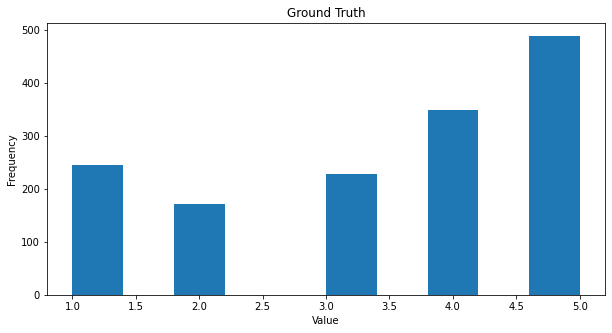

In [283]:
getHistogram(finaldf,'ratingScore', 'Ground Truth')

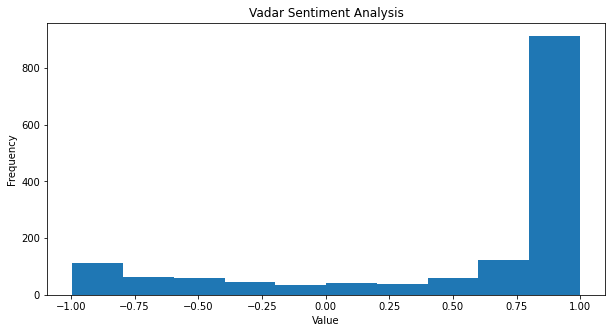

In [284]:
getHistogram(finaldf, 'vader', 'Vadar Sentiment Analysis')

The ground truth sentiment score distributes more even that vadar sentiment analysis. The vadar sentiment is skewed to the left, meaning most of the score is 1.

Text(0, 0.5, 'number of hotels')

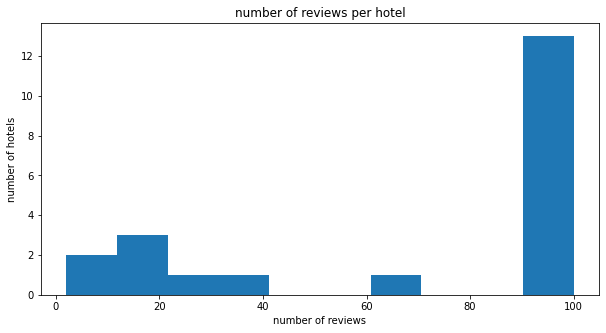

In [285]:
fig = plt.figure(figsize=(10,5))
plt.title("number of reviews per hotel")
plt.hist(finaldf["hotelName"].value_counts())

plt.xlabel("number of reviews")
plt.ylabel("number of hotels")

The number of reviews per hotel is skewed to the left, meaning most of the hotel has nearly 100 reviews.

## b. boxplots

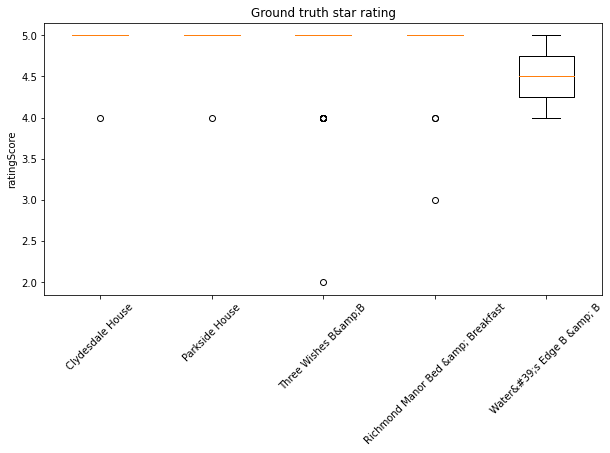

In [286]:
hotel_list = []
for hotel in sort_rating.iloc[:5,:].index.values:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore']
  hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), sort_rating.iloc[:5,:].index.values,rotation=45)
plt.ylabel('ratingScore')
plt.title("Ground truth star rating")
plt.show()

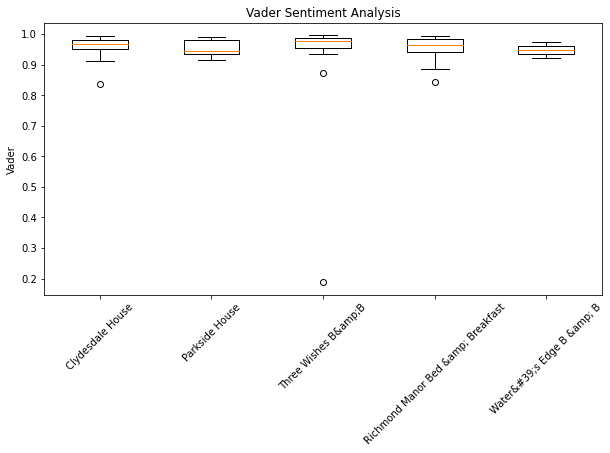

In [287]:
hotel_list_v = []
for hotel in sort_rating.iloc[:5,:].index.values:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['vader']
  hotel_list_v.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list_v)
plt.xticks(np.arange(1,6), sort_rating.iloc[:5,:].index.values,rotation=45)
plt.ylabel('Vader')
plt.title("Vader Sentiment Analysis")
plt.show()

In [288]:
# report mean and variance
mv = pd.DataFrame(columns = ["mean of ground truth", "variance of ground truth", "mean of vader", "variance of vader"])
for hotel in sort_rating.iloc[:5,:].index.values:
  hotel_gt = finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore']
  hotel_v = finaldf.loc[finaldf['hotelName'] == hotel]['vader']

  mv.loc[hotel, mv.columns] = [hotel_gt.mean(), hotel_gt.var(), hotel_v.mean(), hotel_v.var()]

mv

,mean of ground truth,variance of ground truth,mean of vader,variance of vader
Clydesdale House,4.965517,0.034483,0.959966,0.00109
Parkside House,4.857143,0.142857,0.954371,0.000836
Three Wishes B&amp;B,4.823529,0.23705,0.95949,0.009489
Richmond Manor Bed &amp; Breakfast,4.714286,0.373626,0.952257,0.001935
Water&#39;s Edge B &amp; B,4.5,0.5,0.94845,0.001285


Boxplot is more informative. The table only shows the means and variance, while the boxplot shows max, min, 25% quartile, mean, 75% quartile and the outliers. Also boxplot easily visulizes the distribution of data.

## c. scatterplots and heatmaps

Text(0.5, 0, 'Vader Score')

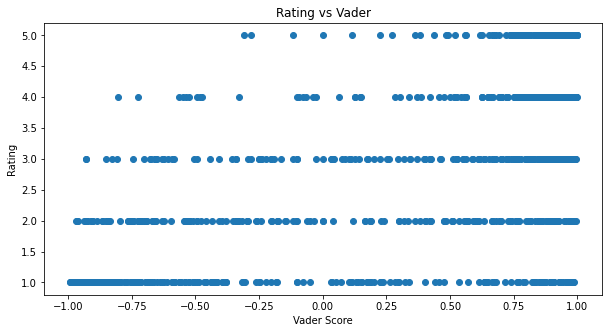

In [289]:
fig = plt.figure(figsize=(10,5))
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
plt.plot(vader_scores, rating_scores,"o")

plt.title('Rating vs Vader')
plt.ylabel("Rating")
plt.xlabel("Vader Score")


In [290]:
from scipy.stats.kde import gaussian_kde
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

<ipython-input-290-2eda73050445>:1: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


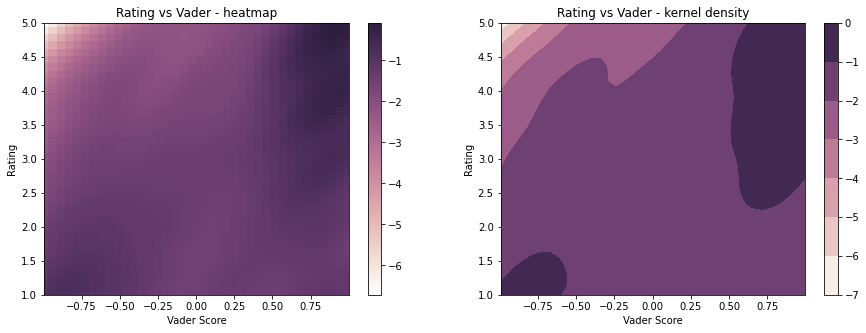

In [291]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Vader - heatmap')
ax2.set_title('Rating vs Vader - kernel density');

the top-right corner and bottom-left corner are most dense. This indicates most the vader sentiment analysis matches the rating score.

Text(0.5, 0, 'Length of reviews')

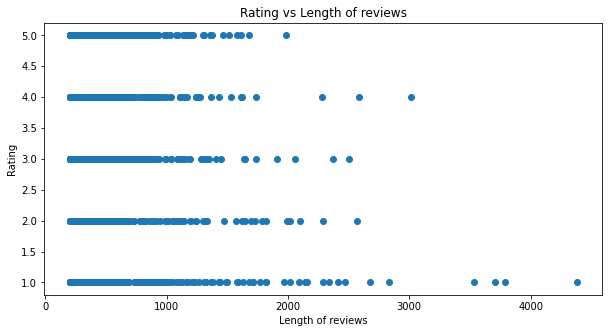

In [292]:
fig = plt.figure(figsize=(10,5))
rating_scores = finaldf['ratingScore'].values
length_scores = finaldf['reviewCol'].str.len().values
plt.plot(length_scores, rating_scores,"o")

plt.title('Rating vs Length of reviews')
plt.ylabel("Rating")
plt.xlabel("Length of reviews")

In [293]:
k_lr = gaussian_kde(np.vstack([length_scores, rating_scores]))
xi_lr, yi_lr = np.mgrid[length_scores.min():length_scores.max():length_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi_lr = k_lr(np.vstack([xi_lr.flatten(), yi_lr.flatten()]))

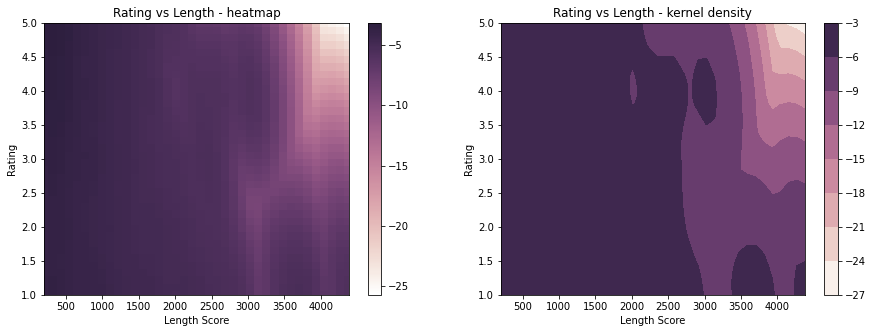

In [294]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi_lr, yi_lr, np.log10(zi_lr.reshape(xi_lr.shape)), cmap=cmap)
b2 = ax2.contourf(xi_lr, yi_lr, np.log10(zi_lr.reshape(xi_lr.shape)), cmap=cmap)

ax1.set_xlim(length_scores.min(), length_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(length_scores.min(), length_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Length Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Length Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Length - heatmap')
ax2.set_title('Rating vs Length - kernel density');

The heatmap shows the length score and rating sentiment scores are not positive correlated, since the top-left and bottom-left corners are the most dense. 

Text(0.5, 0, 'Length of reviews')

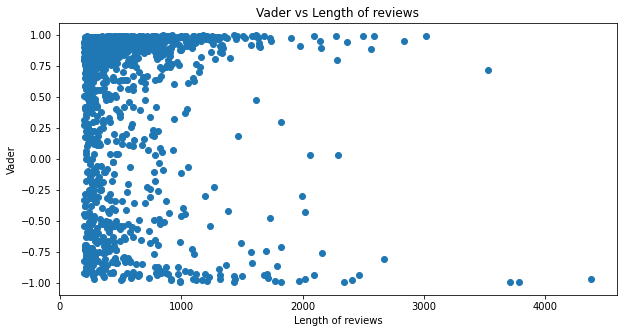

In [295]:
fig = plt.figure(figsize=(10,5))
vader_scores = finaldf['vader'].values
length_scores = finaldf['reviewCol'].str.len().values
plt.plot(length_scores, vader_scores,"o")

plt.title('Vader vs Length of reviews')
plt.ylabel("Vader")
plt.xlabel("Length of reviews")

In [296]:
k_lv = gaussian_kde(np.vstack([length_scores, vader_scores]))
xi_lv, yi_lv = np.mgrid[length_scores.min():length_scores.max():length_scores.size**0.5*1j,vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j]
zi_lv = k_lv(np.vstack([xi_lv.flatten(), yi_lv.flatten()]))

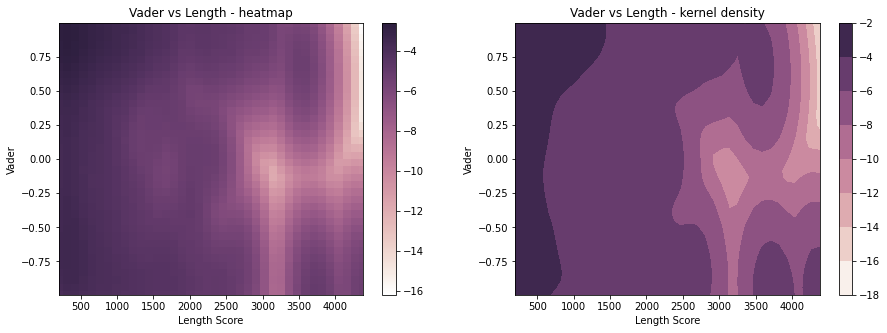

In [297]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi_lv, yi_lv, np.log10(zi_lv.reshape(xi_lv.shape)), cmap=cmap)
b2 = ax2.contourf(xi_lv, yi_lv, np.log10(zi_lv.reshape(xi_lv.shape)), cmap=cmap)

ax1.set_xlim(length_scores.min(), length_scores.max())
ax1.set_ylim(vader_scores.min(), vader_scores.max())
ax2.set_xlim(length_scores.min(), length_scores.max())
ax2.set_ylim(vader_scores.min(), vader_scores.max())

ax1.set_xlabel('Length Score')
ax1.set_ylabel('Vader')

ax2.set_xlabel('Length Score')
ax2.set_ylabel('Vader')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Vader vs Length - heatmap')
ax2.set_title('Vader vs Length - kernel density');

Based on the heatmap and scatterplots, as the length score of reviews increases, the degree of correlation between length score and vader decreases. (the left side is the most dense while the right side is the most light).

Text(0.5, 0, 'number of ratings')

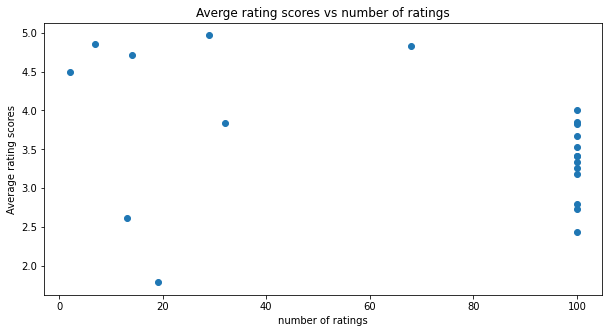

In [298]:
fig = plt.figure(figsize=(10,5))
ratingA_scores = averagedf['Average ground truth rating'].astype(float).values
number_scores = averagedf['number of ratings'].astype(float).values
plt.plot(number_scores, ratingA_scores,"o")

plt.title('Averge rating scores vs number of ratings')
plt.ylabel("Average rating scores")
plt.xlabel("number of ratings")

In [299]:
k_arn = gaussian_kde(np.vstack([number_scores, ratingA_scores]))
xi_arn, yi_arn = np.mgrid[number_scores.min():number_scores.max():number_scores.size**0.5*1j,ratingA_scores.min():ratingA_scores.max():ratingA_scores.size**0.5*1j]
zi_arn = k_arn(np.vstack([xi_arn.flatten(), yi_arn.flatten()]))

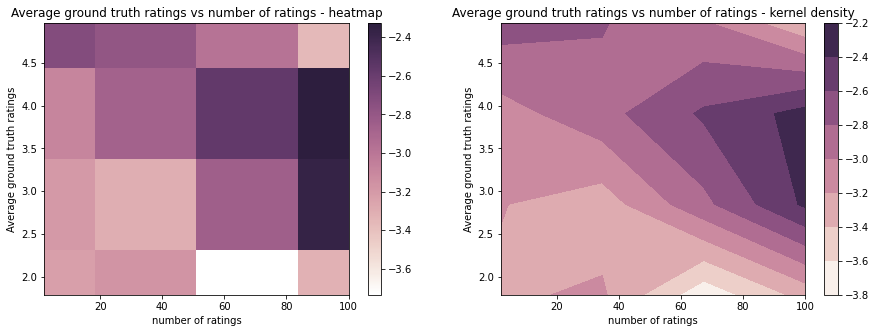

In [300]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi_arn, yi_arn, np.log10(zi_arn.reshape(xi_arn.shape)), cmap=cmap)
b2 = ax2.contourf(xi_arn, yi_arn, np.log10(zi_arn.reshape(xi_arn.shape)), cmap=cmap)

ax1.set_xlim(number_scores.min(), number_scores.max())
ax1.set_ylim(ratingA_scores.min(), ratingA_scores.max())
ax2.set_xlim(number_scores.min(), number_scores.max())
ax2.set_ylim(ratingA_scores.min(), ratingA_scores.max())

ax1.set_xlabel('number of ratings')
ax1.set_ylabel('Average ground truth ratings')

ax2.set_xlabel('number of ratings')
ax2.set_ylabel('Average ground truth ratings')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Average ground truth ratings vs number of ratings - heatmap')
ax2.set_title('Average ground truth ratings vs number of ratings - kernel density');

Hotels have 100 reviews tend to get average ratings between 2.5 and 4.0.

Text(0.5, 0, 'number of ratings')

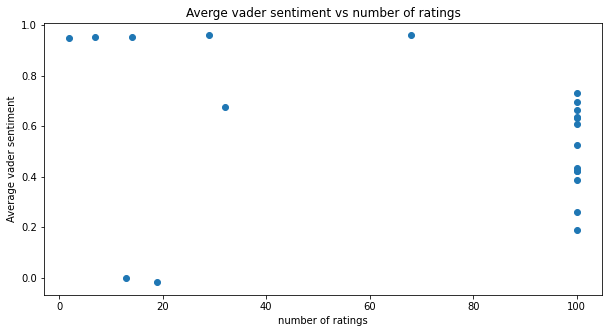

In [301]:
fig = plt.figure(figsize=(10,5))
vaderA_scores = averagedf['Average Vader Sentiment'].astype(float).values
number_scores = averagedf['number of ratings'].astype(float).values
plt.plot(number_scores, vaderA_scores,"o")

plt.title('Averge vader sentiment vs number of ratings')
plt.ylabel("Average vader sentiment")
plt.xlabel("number of ratings")

In [302]:
k_avn = gaussian_kde(np.vstack([number_scores, vaderA_scores]))
xi_avn, yi_avn = np.mgrid[number_scores.min():number_scores.max():number_scores.size**0.5*1j,vaderA_scores.min():vaderA_scores.max():vaderA_scores.size**0.5*1j]
zi_avn = k_avn(np.vstack([xi_avn.flatten(), yi_avn.flatten()]))

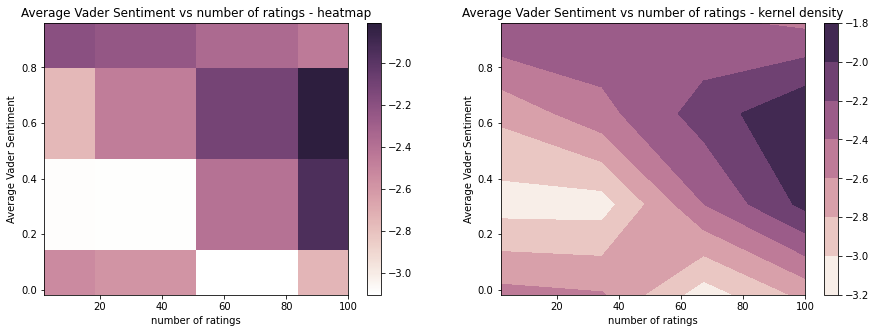

In [303]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi_avn, yi_avn, np.log10(zi_avn.reshape(xi_avn.shape)), cmap=cmap)
b2 = ax2.contourf(xi_avn, yi_avn, np.log10(zi_avn.reshape(xi_avn.shape)), cmap=cmap)

ax1.set_xlim(number_scores.min(), number_scores.max())
ax1.set_ylim(vaderA_scores.min(), vaderA_scores.max())
ax2.set_xlim(number_scores.min(), number_scores.max())
ax2.set_ylim(vaderA_scores.min(), vaderA_scores.max())

ax1.set_xlabel('number of ratings')
ax1.set_ylabel('Average Vader Sentiment')

ax2.set_xlabel('number of ratings')
ax2.set_ylabel('Average Vader Sentiment')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Average Vader Sentiment vs number of ratings - heatmap')
ax2.set_title('Average Vader Sentiment vs number of ratings - kernel density');

The scatterplot and heatmap of number of ratings vs. average vader sentiment score is similar to the vs. average ground truth rating that 75% of the hotels with few ratings (less than 80) get a relative high rating score or vader sentiment score.

## d. Location-based patterns

In [304]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']
  

In [305]:
hotelDf = hotelDf.replace(["('Barrie',)"], "Barrie")

In [306]:
geo_rating_df = averagedf\
                         .join(hotelDf.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)

In [307]:
geo_rating_df

,Average Vader Sentiment,Average ground truth rating,number of ratings,streetAddress,City,Province,postalCode,formed_address
Comfort Inn &amp; Suites,0.434899,3.18,100,210 Essa Rd,Barrie,Ontario,L4N 3L1,"210 Essa Rd, Barrie, Ontario"
"Holiday Inn Express &amp; Suites Barrie, an IHG Hotel",0.732237,4.0,100,506 Bryne Dr,Barrie,Ontario,L4N 9P6,"506 Bryne Dr, Barrie, Ontario"
Comfort Inn - Barrie / Hart Dr.,0.663972,3.42,100,75 Hart Dr,Barrie,Ontario,L4N 5M3,"75 Hart Dr, Barrie, Ontario"
Travelodge by Wyndham Downtown Barrie,0.18806,2.44,100,300 Bayfield St,Barrie,Ontario,L4M 3B9,"300 Bayfield St, Barrie, Ontario"
Three Wishes B&amp;B,0.95949,4.823529,68,48 Steel St,Barrie,Ontario,L4M 2E7,"48 Steel St, Barrie, Ontario"
Horseshoe Resort,0.42365,3.42,100,1101 Horseshoe Valley Rd,Barrie,Ontario,L4M 4Y8,"1101 Horseshoe Valley Rd, Barrie, Ontario"
Monte Carlo Inn Barrie Suites,0.424428,3.34,100,81 Hart Dr,Barrie,Ontario,L4N 5M3,"81 Hart Dr, Barrie, Ontario"
Richmond Manor Bed &amp; Breakfast,0.952257,4.714286,14,16 Blake St,Barrie,Ontario,L4M 1J6,"16 Blake St, Barrie, Ontario"
Quality Inn,0.385173,2.73,100,55 Hart Dr,Barrie,Ontario,L4N 5M3,"55 Hart Dr, Barrie, Ontario"
Clydesdale House,0.959966,4.965517,29,38 Burton Ave,Barrie,Ontario,L4N 2R4,"38 Burton Ave, Barrie, Ontario"


In [308]:
## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter


# 0 - need to give the tool a generic name.
locator = Photon(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df.head()

<ipython-input-308-37f345b45f5f>:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


,Average Vader Sentiment,Average ground truth rating,number of ratings,streetAddress,City,Province,postalCode,formed_address,location,point,latitude,longitude,altitude
Comfort Inn &amp; Suites,0.434899,3.18,100,210 Essa Rd,Barrie,Ontario,L4N 3L1,"210 Essa Rd, Barrie, Ontario","(210, Essa Road, L4N 3L1, Essa Road, Barrie, O...","(44.3642017, -79.6970575, 0.0)",44.364202,-79.697057,0.0
"Holiday Inn Express &amp; Suites Barrie, an IHG Hotel",0.732237,4.0,100,506 Bryne Dr,Barrie,Ontario,L4N 9P6,"506 Bryne Dr, Barrie, Ontario","(506, Bryne Drive, L4N 9R1, Bryne Drive, Barri...","(44.3316854196405, -79.68907110346763, 0.0)",44.331685,-79.689071,0.0
Comfort Inn - Barrie / Hart Dr.,0.663972,3.42,100,75 Hart Dr,Barrie,Ontario,L4N 5M3,"75 Hart Dr, Barrie, Ontario","(75, Hart Drive, L4N 5M3, Hart Drive, Barrie, ...","(44.37778504414698, -79.71125594792137, 0.0)",44.377785,-79.711256,0.0
Travelodge by Wyndham Downtown Barrie,0.18806,2.44,100,300 Bayfield St,Barrie,Ontario,L4M 3B9,"300 Bayfield St, Barrie, Ontario","(300, Bayfield Street, L4M 3C1, Bayfield Stree...","(44.4001652, -79.699736, 0.0)",44.400165,-79.699736,0.0
Three Wishes B&amp;B,0.95949,4.823529,68,48 Steel St,Barrie,Ontario,L4M 2E7,"48 Steel St, Barrie, Ontario","(48, Steel Street, L4M 2E7, Steel Street, Barr...","(44.40233507083333, -79.67037499166666, 0.0)",44.402335,-79.670375,0.0


In [309]:
import folium

map1 = folium.Map(
    location=[44.389355,-79.690331], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=12,
)

geo_rating_df.dropna().apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], color='#d7191c', popup='Average ground truth rating: {:.2f}'.format(row['Average ground truth rating'])).add_to(map1), axis=1)

map1

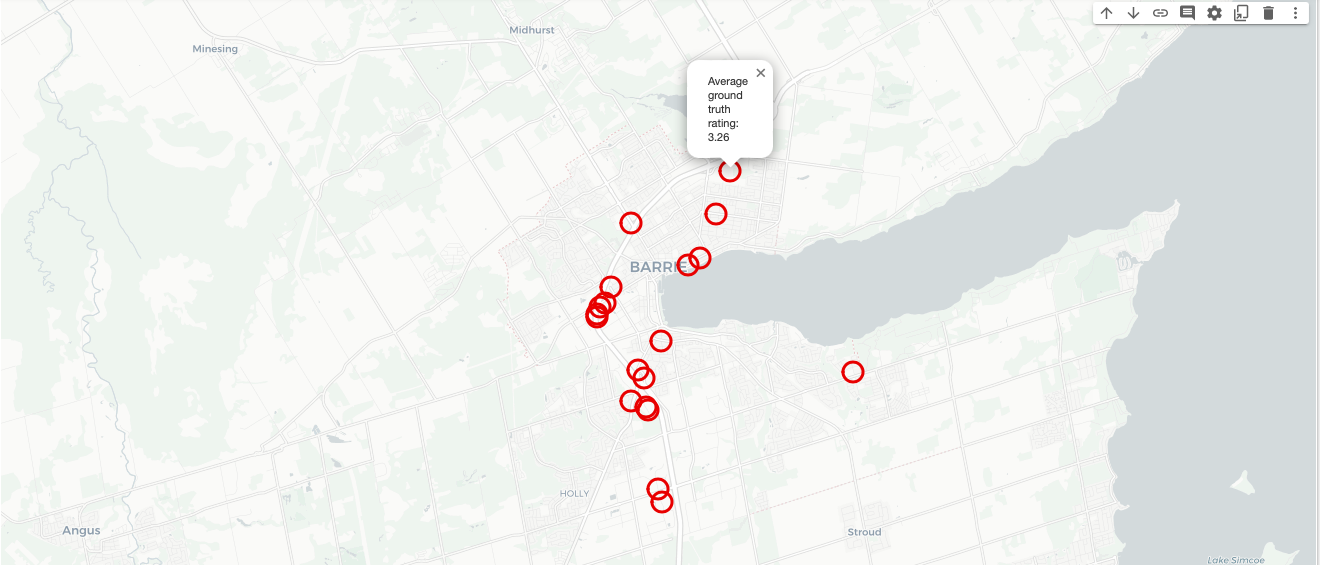

In [310]:
## folium graphs are best saved as screenshot images to be reloaded into the notebook

from IPython.display import Image
Image('demo.png')

Based on the map, 2 lowly rated hotels are all located at intersection of highway400 and Dunlop St.W. But there are still some other hotels have a higher average rating score in the same location. 

Compared to all the locations, I may recommend guests choose the hotel near the lake since the average rating score is relative higher.

## Temporal analysis

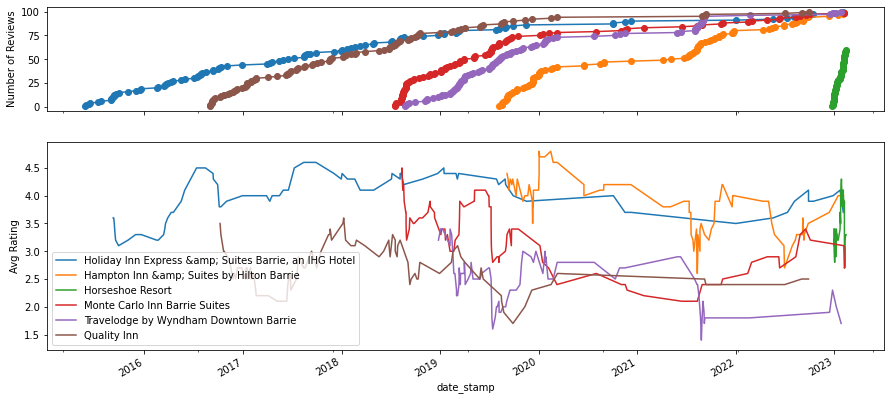

In [311]:
# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})
sample_hotel = ["Holiday Inn Express &amp; Suites Barrie, an IHG Hotel", "Hampton Inn &amp; Suites by Hilton Barrie",
                "Horseshoe Resort", "Monte Carlo Inn Barrie Suites",
                "Travelodge by Wyndham Downtown Barrie", "Quality Inn"]
for hotel in sample_hotel: 
  _df = hotelDf[hotelDf['hotelName']==hotel].set_index('date_stamp')
  # create a regular expression to match index labels ending with "... ago" or "yesterday
  dropidx = [idx for idx in _df.index if re.compile(r'\d+\s+(days|weeks|week)\s+ago|yesterday').match(idx)]

  # remove the rows with the matching index labels
  _df.drop(dropidx, inplace=True)

  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')

  #with a rolling window of 10 reviews
  _df['ratingScore'].rolling(10).mean().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

Most of the sample hotels have smooth curves and remains stable within a rating range. However the Monte Carlo Inn Barrie Suites has a significant fluctation from 2.0 to 4.0.

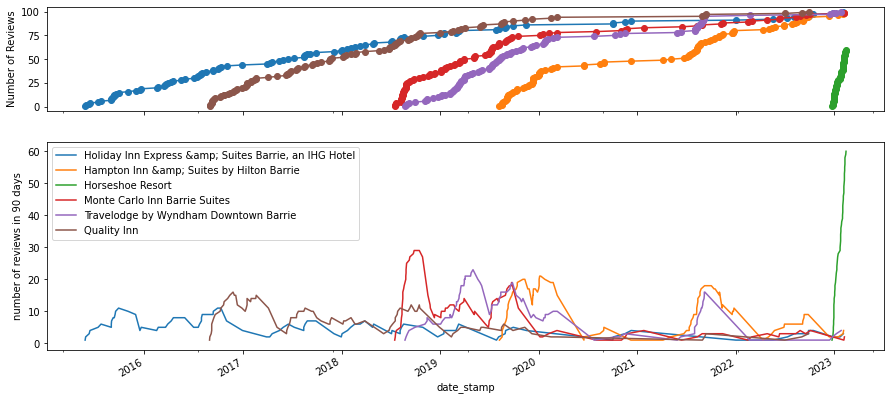

In [312]:
#number of reviews in 90 days

fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})
sample_hotel = ["Holiday Inn Express &amp; Suites Barrie, an IHG Hotel", "Hampton Inn &amp; Suites by Hilton Barrie",
                "Horseshoe Resort", "Monte Carlo Inn Barrie Suites",
                "Travelodge by Wyndham Downtown Barrie", "Quality Inn"]
for hotel in sample_hotel: 
  _df = hotelDf[hotelDf['hotelName']==hotel].set_index('date_stamp')
  # create a regular expression to match index labels ending with "... ago" or "yesterday
  dropidx = [idx for idx in _df.index if re.compile(r'\d+\s+(days|weeks|week)\s+ago|yesterday').match(idx)]

  # remove the rows with the matching index labels
  _df.drop(dropidx, inplace=True)

  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')

  #with a rolling window of 90 days
  _df['count'].rolling('90D').sum().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('number of reviews in 90 days')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

We could observe that "Holiday Inn Express &amp; Suites Barrie, an IGH Hotel" and "Quality Inn" have a smooth curve on rate of reviews. But one is a highly rated hotel and the other one is a lowly rated hotel. This may becase the highly rated hotel has a good reputation, it already has a stable customer base, resulting in a stable rate of reviews. On the other hand, the other one has a poor reputation, and therefore receives fewer visitors, resulting in a low rate of reviews.

In addition, we can observe that the trends of three hotels occasionally increase and then decrease, and during the fluctuation period, their average rating score also changes accordingly.

There is also a hotel (represented by the green line) that continues to grow, which is a newly opened hotel, so we can see a significant increase in both rate of reviews and average rating score in the short term. It will take time to observe and determine the overall quality of the hotel.